<div>
<img src="figures/svtLogo.png"/>
</div>

<center><h1>Mathematical Optimization for Engineers</h1></center>
<center><h2>Bonus exercise 2</h2></center>

In Lecture 10, you learn about methods for deterministic global optimization of non-linear *non-convex* functions. One of these methods is the Branch-and-Bound method where the feasible set is iteratively branched and pruned, based on a check against estimated upper and lower bounds on the optimal solution. In this exercise, you will implement the  bounding procedure for problems of the following class:

\begin{align} \label{eq:optprob}
  \min_{\boldsymbol{x}\in\mathbb{R}^n}\;& \boldsymbol{x}^T\boldsymbol{H}\boldsymbol{x} + \boldsymbol{c}^T\boldsymbol{x}\\
  \mathrm{s.t.}\; & \boldsymbol{x}^T\boldsymbol{Q}_i\boldsymbol{x} + \boldsymbol{a}_i\boldsymbol{x} = b_i\; \forall\; i\in\, \{1,...,m\}\\
  & \boldsymbol{x}^L \leq \boldsymbol{x} \leq \boldsymbol{x}^U
\end{align}

with $n,m\in\mathbb{N}$, $m<n$, a symmetric, positive semidefinite matrix $\boldsymbol{H}\in\mathbb{R}^{n\times n}$, symmetric indefinite matrices $\boldsymbol{Q}_i\in\mathbb{R}^{n\times n}\,\forall i\in \{1,...,m\}$, $\boldsymbol{c}\in\mathbb{R}^n$, $\boldsymbol{A}\in\mathbb{R}^{m\times n}$ with row vectors $\boldsymbol{a}_i$, and $\boldsymbol{b}\in\mathbb{R}^m$.
The above problem is a nonconvex optimization problem with the possibility of suboptimal local minima.

Example 1 fits into this formulation: 
\begin{align}
  \min_{\boldsymbol{x}\in \mathbb{R}^3}\;& x_1 + x_2 + x_3^2\\
  \mathrm{s.t.}\; & x_1x_2 + x_3 = 8\\
  &x_2x_3 = 15 \\
  & 0 \leq x_1, x_2, x_3 \leq 10
\end{align}

The terms $x_1x_2$ and $x_2x_3$, which are responsible for the non-convexity of the model, are called *bilinear* terms.
In example 1, the matrices and vectors in the general problem definition would be
\begin{align}
  \begin{array}{ccc}
  \boldsymbol{c} = \left[1,1,0\right]^T,&\boldsymbol{b} = \left[8,15\right]^T, &\boldsymbol{A} = \left[\begin{array}{ccc}0&0&1\\0&0&0\end{array}\right]\\\boldsymbol{H} = \left[\begin{array}{ccc}0&0&0\\0&0&0\\0&0&1\end{array}\right]\,&
  \boldsymbol{Q}_1 = \left[\begin{array}{ccc}0&0.5&0\\0.5&0&0\\0&0&0\end{array}\right],\,&
  \boldsymbol{Q}_2 = \left[\begin{array}{ccc}0&0&0\\0&0&0.5\\0&0.5&0\end{array}\right]
\end{array}
\end{align}

### The Algorithm
In order to get a lower bound on the objective value of the nonconvex optimization problem, we need to construct a *convex relaxation* and solve it to global optimality.
One widely used relaxation of the *bilinear* terms $x_ix_j$ are the so-called *McCormick Envelopes*.
The relaxation works as follows:
each term $x_ix_j$ is replaced by an auxiliary variable $w_{ij}$.
Then, the following constraints for $w_{ij}$ are defined:

\begin{align}
  w_{ij} &\geq x_i^Lx_j + x_ix_j^L - x_i^Lx_j^L\label{eq:mcccormick1}\\
  w_{ij} &\geq x_i^Ux_j + x_ix_j^U -x_i^Ux_j^U\label{eq:mcccormick2}\\
  w_{ij} &\leq x_i^Ux_j+x_ix_j^L -x_i^Ux_j^L\label{eq:mcccormick3}\\
  w_{ij} &\leq x_i^Lx_j+x_ix_j^U -x_i^Lx_j^U\label{eq:mcccormick4}
\end{align}

These constraints are added to the original optimization problem, and the bilinear terms are replaced with the variables $w_{ij}$.
The resulting convex QP (quadratic objective \& linear constraints) is solved using standard methods, yielding a lower bound on the objective value of \eqref{eq:optprob}.


Be sure that you can run the code by running *Run All*. 

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import cm

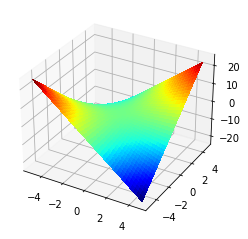

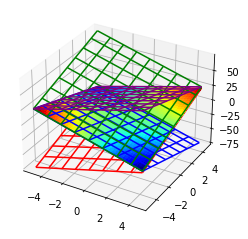

In [2]:
#%matplotlib notebook
# uncomment the first line to have interactive plots

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X_l = -5
X_u = +5
Y_l = -5
Y_u = +5
# Make data.
X = np.arange(X_l, X_u, 0.25)
Y = np.arange(Y_l, Y_u, 0.25)
X, Y = np.meshgrid(X, Y)
Z = (X * Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.jet,
                       linewidth=0, antialiased=False)


# Envelopes
Z1 = (X_l * Y + X * Y_l - X_l * Y_l)
Z2 = (X_u * Y + X * Y_u - X_u * Y_u)
Z3 = (X_u * Y + X * Y_l - X_u * Y_l)
Z4 = (X_l * Y + X * Y_u - X_l * Y_u)

fig1, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax1.plot_surface(X, Y, Z, cmap=cm.jet,
                       linewidth=0, antialiased=False)
surf = ax1.plot_wireframe(X, Y, Z1, rstride=5, cstride=5, color='blue')
surf = ax1.plot_wireframe(X, Y, Z2, rstride=5, cstride=5, color='red')
surf = ax1.plot_wireframe(X, Y, Z3, rstride=5, cstride=5, color='green')
surf = ax1.plot_wireframe(X, Y, Z4, rstride=5, cstride=5, color='purple')


In [3]:
def convex_bounds(n,m,c,H,Q,A,b,lb,ub):
    #   70 points
    #   n is the number of optimization variables
    #   m is the number of eq constraints
    #   H = positive, semidefinite matrix from objetcive function (n x n)
    #   Q is (mxn) x n 
    #   A is m x n
    #   b is RHS of non linear eq constraints (m x 1)
    #   c,lb,ub are vectors size (n x 1)
    
    
    def check_symmetric(a, rtol=1e-05, atol=1e-08):
        return np.allclose(a, a.T, rtol=rtol, atol=atol)    
    
    # initialize bounds
    fub = float("inf")
    flb = -float("inf")
    
    # Symmetry test
    #   Check all Qi matrices for symmetry 
    for i in range(m):
        Qi = Q[ i*n : (i+1)*n , :]
        if (not(check_symmetric(Qi))):
            print("Matrix Q{:d} not symmetric. Check input.".format(i+1))
            return fub, flb

    # Dimension test
    if (np.shape(Q)[0] != m*n or np.shape(Q)[1] != n):
        print("Matrix Q has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(b) != m):
        print("Vector b has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(c) != n):
        print("Vector c has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(lb) != n):
        print("Vector lb has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(ub) != n):
        print("Vector ub has incorrect dimensions. Check input.")
        return fub, flb
    
    if (np.shape(H)[0] != n or np.shape(H)[1] != n):
        print("Matrix H has incorrect dimensions. Check input.")
        return fub, flb 
    
    if (np.shape(A)[0] != m or np.shape(A)[1] != n):
        print("Matrix A has incorrect dimensions. Check input.")
        return fub, flb
    
    # Inspect matices Qi & generate auxilliary variables
    # The Matrix A will be appended with the entries that correspond to 
    # the auxiliary variables wij.
    #   If we do not check for already existing combinations, 
    #   then the same combination x_i.x_j might be treated as
    #   different aux vars in different constraints
    
    # counter variable (count) to know the number of bilinear terms
    count = 1 #####------------------------------------------------------->>>>>>>>>>>>>value of count changed
    combination_exists = 0 #(already taken exists)  
    # initialize w_combination to [-1,-1]
    w_combination = -1*np.ones((1,2))
    # initialize A_help (to be appended later to A)
    A_help = np.zeros((m,1))
    
    # you need to determine which bilinear terms exist and decide wether a combination x_i*x_j already exists
    # Each bilinear term may only be relaxed once.
    # Hint: Is there a difference between x1*x2 and x2*x1? (No)
    # Do we need to consider all entries of Qi? (No, because it is symmetric)

    # You need to consider all constraints
    # You need to check which bilinear terms are present in each contraint
    # the variables w_combination and A_help will be populated. 
    
    ### YOUR CODE HERE
    k = 0
    i = 0
    j = 0
    l = 0
    count_each=0
    index = [] #To count number of bilinear terms in each constraint equation
    A_help = np.zeros((m,1))
    for k in range (m):
        for i in range(n):
            for j in range(i+1):
                if Q[i+n*k, j]!=0:
                    index.append((i,j))
                    count_each = count_each+1
                    A_help[l,0]=1
                l=l+1
            l=0
        if count_each>0:
            A = np.hstack((A,A_help))
        A_help = np.zeros((m,1))  
        count_each=0
        i=0
        j=0
    unq_combo = set(index) #To keep unique bilinear terms
    count = len(unq_combo)
    # append A_help to A
    #if count>0:
        #Aeq = np.hstack((A, A_help))
    #else:
    Aeq = A
    
    # Create matrix B & b_ineq for inequality constraints
    # where B*x <= b_ineq
    
    ### YOUR CODE HERE
    B = np.zeros((4*count,n+count))
    b_ineq = np.zeros((4*count))
    i = 0
    j = 0
    k = 0
    q = 0
    t = 0
    for k in unq_combo:
        j=k[0]
        i=k[1]
        B[0+4*q,i] = lb[j]
        B[0+4*q,j] = lb[i]
        B[0+4*q,n+t] = -1
        B[1+4*q,i] = ub[j]
        B[1+4*q,j] = ub[i]
        B[1+4*q,n+t] = -1
        B[2+4*q,i] = -1*lb[j]
        B[2+4*q,j] = -1*ub[i]
        B[2+4*q,n+t] = 1
        B[3+4*q,i] = -1*ub[j]
        B[3+4*q,j] = -1*lb[i]
        B[3+4*q,n+t] = 1
        b_ineq[0+4*q] = lb[i]*lb[j]
        b_ineq[1+4*q] = ub[i]*ub[j]
        b_ineq[2+4*q] = -1*ub[i]*lb[j]
        b_ineq[3+4*q]
        t = t+1
        q = q+1
    
            
    # Initialization of remaining components
    lb_relax = np.append(lb, float('-inf')*np.ones(count))
    ub_relax = np.append(ub, float('inf')*np.ones(count))
    
    
    H_relax = None
    c_relax = None

    # rest of H matrix and C vector must be filled with 0
    if count>0: 
        H_relax = np.hstack((H, np.zeros((n, count))))
        H_relax = np.vstack((H_relax, np.zeros((count, n + count))))
        c_relax = np.hstack((c, np.zeros(count)))
    else:
        H_relax = H
        c_relax = c
            
        
    x0 = np.ones((n + count))
    #x0 = np.ones(n+1)
    
    def cvxRelax(x):
        return (np.dot(x.T, np.dot(H_relax, x))+ np.dot(c_relax, x))
    
    def jac(x):
        return (2*np.dot(x.T, H_relax) + c_relax)
    
    ineq_cons  = {'type':'ineq',
        'fun':lambda x: b_ineq - np.dot(B,x),
        'jac':lambda x: -B}
    
    eq_cons  = {'type':'eq',
        'fun':lambda x: b - np.dot(Aeq,x),
        'jac':lambda x: -Aeq}
    
    bounds = optimize.Bounds(lb_relax, ub_relax)
    
    opt = {'disp':True}
    # call optimization for relaxed problem 
    # HINTS:
    # res_lb = ...
    # method='SLSQP', jac=jac,constraints=[eq_cons, ineq_cons], options=opt
    
    ### YOUR CODE HERE
    res_lb = optimize.minimize(cvxRelax, x0, bounds=bounds, method='SLSQP', jac=jac,constraints=[eq_cons, ineq_cons], options=opt)
    return res_lb['fun']

In [4]:
def solve_original_problem(n,m,c,H,Q,A,b,lb,ub):
    # 10 points
    def objective(x):
        return (np.dot(x.T, np.dot(H, x))+ np.dot(c, x))
    
    def eq_cons(x): 
        c = np.zeros(m)
        for i in range(m): 
            c[i] = 1
        return c
    
    x0 = np.ones(n)
    bounds = optimize.Bounds(lb, ub)
    opt = {'disp':True}
    my_equalities = optimize.NonlinearConstraint(eq_cons, np.zeros(m), np.zeros(m))

    res_ub = optimize.minimize(objective, x0, constraints=[my_equalities],
                            method='SLSQP',bounds=bounds, options=opt)
    return res_ub['fun']

### Example 1

\begin{align}
  \min_{\boldsymbol{x}\in \mathbb{R}^3}\;& x_1 + x_2 + x_3^2\\
  \mathrm{s.t.}\; & x_1x_2 + x_3 = 8\\
  &x_2x_3 = 15 \\
  & 0 \leq x_1, x_2, x_3 \leq 10
\end{align}


#### Hint 
The value of the valid lower bound is 4.4 and for the upper bound 12.276. 

In [5]:
# problem definition
n = 3
m = 2
c = [1, 1, 0]
b = [8,15]
A = np.zeros((2,3))
A[0,2] = 1

H = np.zeros((3,3))
H[2,2] = 1

Q1 = np.zeros((3,3))
Q1[0,1] = 0.5
Q1[1,0] = 0.5
Q2 = np.zeros((3,3))
Q2[2,1] = 0.5
Q2[1,2] = 0.5
Q = np.vstack((Q1, Q2))

# bounds
lb = [0,0,0]
ub = [10,10,10]

f_lb = convex_bounds(n, m, c, H, Q, A, b, lb, ub)
print("Lower bound is: ", f_lb)
f_ub = solve_original_problem(n, m, c, H, Q, A, b, lb, ub)
print("Upper bound is: ", f_ub)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.4
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Lower bound is:  4.4
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 3.0
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Upper bound is:  3.0


### Example 2

\begin{align}
	\min_{\boldsymbol{x}\in \mathbb{R}^4}\;& x_1 + x_2 + x_3^2 + x_{4}^2\\
	\mathrm{s.t. \,}\; & x_1x_2 + x_{2}x_3 = 2\\
	&x_1x_2 + x_{4} = 3 \\
	&x_{1} + x_{2}x_{3} = 5 \\
	& 0 \leq x_1, x_3, x_4 \leq 10 \\
	& 0 \leq x_{2} \leq 4
\end{align}

#### Hint 
The value of the valid lower bound is 6.2 and 6.4 for the upper bound.

In [6]:
# define the optimization problem
# 20 points
### YOUR CODE HERE
n = 4
m = 3
H = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
Q1 = np.zeros((n,n))
Q1[1,0] = 0.5
Q1[0,1] = 0.5
Q1[2,1] = 0.5
Q1[1,2] = 0.5
Q2 = np.zeros((n,n))
Q2[1,0] = 0.5
Q2[0,1] = 0.5
Q3 = np.zeros((n,n))
Q3[2,1] = 0.5
Q3[1,2] = 0.5
Q = np.vstack((Q1,Q2,Q3))
A = np.array([[0, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0]])
b = np.array((m,1))
b = [2, 3, 5]
c = np.array(n)
c = [1, 1, 0, 0]
lb = np.array(n)
lb = [0, 0, 0, 0]
ub = np.array(n)
ub = [10, 2, 10, 10]
f_lb = convex_bounds(n, m, c, H, Q, A, b, lb, ub)
print("Lower bound is: ", f_lb)
f_ub = solve_original_problem(n, m, c, H, Q, A, b, lb, ub)
print("Upper bound is: ", f_ub)

ValueError: shapes (3,7) and (6,) not aligned: 7 (dim 1) != 6 (dim 0)